#  "摩拜"需要我

在这节课中，我们将设计人工神经网络对某地区租赁单车的使用情况进行预测，我们将这个问题分解为三个小问题：

1. 输入节点为1个，隐含层为10个，输出节点数为1的小型人工神经网络，用数据的下标预测单车数量
2. 输入节点为56个，隐含层为10个，输出节点数为1的人工神经网络，用数据库中的星期几、是否节假日、温度、湿度等属性预测单车数量
3. 输入节点为56个，隐含层节点数为10个，输出节点数为2个的人工神经网络，用数据库中的星期几、是否节假日、温度、湿度等属性预测单车数量是大于平均值还是小于平均值

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [1]:
#导入需要使用的库
import numpy as np
import pandas as pd #读取csv文件的库
import matplotlib.pyplot as plt
import torch
#from torch.autograd import Variable
import torch.optim as optim

# 让输出的图形直接在Notebook中显示
%matplotlib inline

## 一、准备工作：读入数据文件

首先，我们读入数据，绘制图形，看看数据长成什么样子

In [2]:
#读取数据到内存中，rides为一个dataframe对象
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

#看看数据长什么样子
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


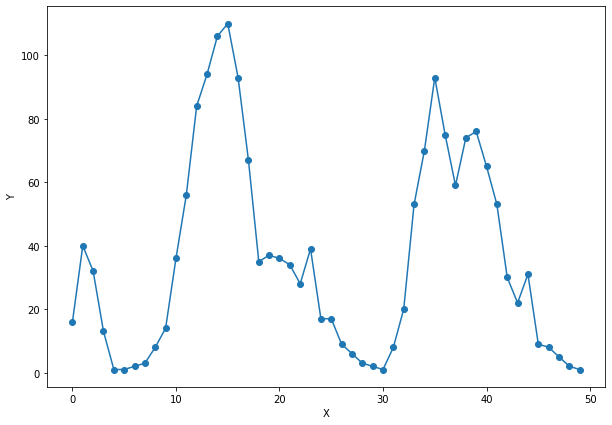

In [3]:
#我们取出最后一列的前50条记录来进行预测
counts = rides['cnt'][:50]

#获得变量x，它是1，2，……，50
x = np.arange(len(counts))

# 将counts转成预测变量（标签）：y
y = np.array(counts)

# 绘制一个图形，展示曲线长的样子
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
plt.plot(x, y, 'o-') # 绘制原始数据
plt.xlabel('X') #更改坐标轴标注
plt.ylabel('Y') #更改坐标轴标注
plt.show()

### 线性回归尝试

我们可以先尝试用线性回归来对曲线进行拟合，复习一下上节课学过的内容，尽管效果很差

In [15]:
#我们取出数据库的最后一列的前50条记录来进行预测
counts = rides['cnt'][:50]

# 创建变量x，它是1，2，……，50
x = torch.tensor(np.arange(len(counts)), dtype=torch.double, requires_grad = True)

# 将counts转成预测变量（标签）：y
y = torch.tensor(np.array(counts), dtype=torch.double, requires_grad = True)

a = torch.rand(1, dtype=torch.double, requires_grad = True) #创建a变量，并随机赋值初始化
b = torch.rand(1, dtype=torch.double, requires_grad = True) #创建b变量，并随机赋值初始化
print('Initial parameters:', [a, b])
learning_rate = 0.00001 #设置学习率
for i in range(10000):
    ### 增加了这部分代码，清空存储在变量a，b中的梯度信息，以免在backward的过程中会反复不停地累加
    predictions = a * x+ b  #计算在当前a、b条件下的模型预测数值
    loss = torch.mean((predictions - y) ** 2) #通过与标签数据y比较，计算误差
    print('loss:', loss)
    loss.backward() #对损失函数进行梯度反传
    a.data.add_(- learning_rate * a.grad.data)  #利用上一步计算中得到的a的梯度信息更新a中的data数值
    b.data.add_(- learning_rate * b.grad.data)  #利用上一步计算中得到的b的梯度信息更新b中的data数值
    a.grad.data.zero_() #清空a的梯度数值
    b.grad.data.zero_() #清空b的梯度数值

Initial parameters: [tensor([0.8406], dtype=torch.float64, requires_grad=True), tensor([0.4176], dtype=torch.float64, requires_grad=True)]
loss: tensor(1396.0656, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1394.7833, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1393.5420, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1392.3404, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1391.1773, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1390.0514, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1388.9616, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1387.9066, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1386.8854, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1385.8969, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1384.9400, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1384.0137, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1383.117

loss: tensor(1355.1335, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1299, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1263, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1227, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1191, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1155, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1119, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1083, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1047, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.1011, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.0975, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.0940, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.0904, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.0868, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1355.08

loss: tensor(1354.1151, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.1116, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.1081, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.1045, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.1010, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0975, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0939, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0904, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0868, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0833, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0798, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0762, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0727, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.0692, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1354.06

loss: tensor(1353.0132, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1353.0097, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1353.0062, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1353.0027, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9991, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9956, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9921, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9885, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9850, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9815, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9780, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9744, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9709, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.9674, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1352.96

loss: tensor(1351.9078, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.9043, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.9008, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8973, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8938, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8902, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8867, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8832, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8797, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8762, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8727, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8692, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8656, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.8621, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1351.85

loss: tensor(1350.9532, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9496, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9461, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9426, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9391, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9356, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9321, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9286, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9251, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9216, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9181, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9146, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9111, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.9076, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.90

loss: tensor(1350.0151, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.0116, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.0081, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.0046, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1350.0011, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9977, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9942, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9907, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9872, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9837, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9802, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9767, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9732, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.9697, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.96

loss: tensor(1349.1738, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1703, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1668, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1634, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1599, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1564, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1529, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1494, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1459, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1424, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1390, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1355, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1320, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.1285, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1349.12

loss: tensor(1348.3207, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.3172, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.3137, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.3102, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.3068, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.3033, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2998, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2963, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2929, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2894, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2859, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2824, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2789, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.2755, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1348.27

loss: tensor(1347.5079, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.5044, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.5009, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4974, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4940, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4905, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4870, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4836, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4801, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4766, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4732, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4697, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4662, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.4628, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1347.45

loss: tensor(1346.5067, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.5032, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4998, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4963, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4928, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4894, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4859, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4825, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4790, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4755, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4721, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4686, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4652, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.4617, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1346.45

loss: tensor(1345.4843, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4809, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4774, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4740, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4705, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4671, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4636, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4602, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4567, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4533, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4498, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4464, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4429, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.4395, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1345.43

loss: tensor(1344.4960, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4926, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4892, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4857, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4823, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4788, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4754, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4720, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4685, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4651, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4617, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4582, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4548, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.4513, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1344.44

loss: tensor(1343.5621, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5587, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5552, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5518, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5484, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5449, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5415, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5381, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5347, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5312, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5278, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5244, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5209, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.5175, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1343.51

loss: tensor(1342.6581, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6547, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6513, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6479, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6444, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6410, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6376, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6342, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6308, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6273, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6239, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6205, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6171, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.6137, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1342.61

loss: tensor(1341.6304, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6270, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6236, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6202, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6168, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6134, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6100, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6066, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.6032, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.5997, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.5963, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.5929, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.5895, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.5861, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1341.58

loss: tensor(1340.7181, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.7147, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.7113, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.7079, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.7045, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.7011, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6977, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6943, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6909, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6875, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6841, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6807, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6773, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.6739, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1340.67

loss: tensor(1339.8117, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.8083, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.8049, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.8015, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7981, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7947, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7913, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7879, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7845, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7811, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7778, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7744, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7710, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.7676, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1339.76

loss: tensor(1338.9010, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8976, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8942, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8908, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8874, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8840, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8807, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8773, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8739, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8705, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8671, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8638, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8604, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.8570, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1338.85

loss: tensor(1337.8782, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8748, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8714, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8680, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8647, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8613, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8579, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8546, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8512, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8478, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8444, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8411, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8377, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.8343, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1337.83

loss: tensor(1336.8417, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8384, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8350, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8317, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8283, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8249, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8216, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8182, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8149, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8115, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8081, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8048, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.8014, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.7981, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1336.79

loss: tensor(1335.8521, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8488, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8454, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8421, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8387, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8354, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8320, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8287, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8254, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8220, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8187, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8153, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8120, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.8086, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1335.80

loss: tensor(1334.8923, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8889, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8856, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8822, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8789, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8756, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8722, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8689, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8656, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8622, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8589, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8555, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8522, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.8489, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.84

loss: tensor(1334.0584, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0551, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0518, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0485, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0451, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0418, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0385, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0351, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0318, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0285, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0251, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0218, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0185, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.0151, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1334.01

loss: tensor(1333.1470, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1437, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1404, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1371, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1338, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1304, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1271, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1238, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1205, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1171, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1138, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1105, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1072, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.1039, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1333.10

loss: tensor(1332.2051, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.2018, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1985, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1951, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1918, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1885, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1852, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1819, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1786, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1753, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1720, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1686, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1653, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.1620, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1332.15

loss: tensor(1331.2956, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2923, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2890, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2857, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2824, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2791, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2758, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2725, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2692, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2659, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2626, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2593, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2560, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.2527, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1331.24

loss: tensor(1330.3261, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3228, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3195, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3162, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3129, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3096, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3063, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.3031, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.2998, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.2965, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.2932, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.2899, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.2866, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.2833, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1330.28

loss: tensor(1329.3300, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3267, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3234, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3202, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3169, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3136, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3103, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3070, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3037, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.3005, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.2972, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.2939, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.2906, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.2873, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1329.28

loss: tensor(1328.3632, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3599, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3566, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3534, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3501, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3468, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3436, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3403, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3370, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3337, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3305, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3272, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3239, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.3207, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1328.31

loss: tensor(1327.3373, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3341, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3308, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3275, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3243, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3210, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3178, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3145, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3112, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3080, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3047, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.3014, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.2982, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.2949, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1327.29

loss: tensor(1326.5229, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5197, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5164, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5132, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5099, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5067, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5034, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.5001, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.4969, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.4936, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.4904, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.4871, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.4839, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.4806, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1326.47

loss: tensor(1325.7236, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7203, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7171, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7139, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7106, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7074, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7041, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.7009, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.6976, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.6944, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.6911, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.6879, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.6846, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.6814, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1325.67

loss: tensor(1324.7677, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7645, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7612, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7580, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7548, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7515, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7483, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7451, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7418, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7386, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7354, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7321, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7289, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.7256, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1324.72

loss: tensor(1323.8470, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8438, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8405, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8373, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8341, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8308, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8276, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8244, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8212, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8179, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8147, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8115, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8083, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.8050, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1323.80

loss: tensor(1322.8871, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8839, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8807, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8775, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8743, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8711, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8678, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8646, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8614, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8582, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8550, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8518, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8485, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.8453, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(1322.84

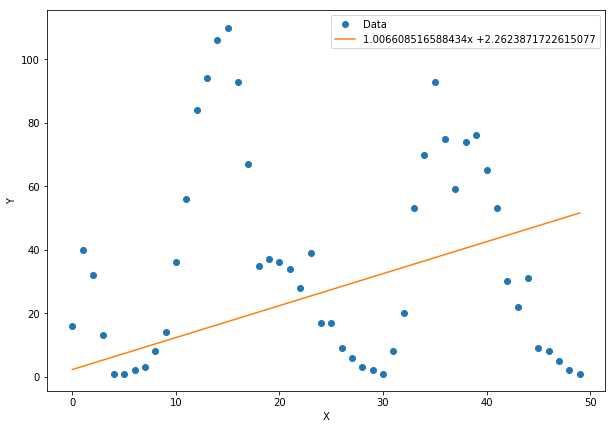

In [16]:
# 绘制图形，展现线性回归的效果，结果惨不忍睹

x_data = x.data.numpy() # 获得x包裹的数据
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') # 绘制原始数据

yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X') #更改坐标轴标注
plt.ylabel('Y') #更改坐标轴标注
str1 = str(a.data.numpy()[0]) + 'x +' + str(b.data.numpy()[0]) #图例信息
plt.legend([xplot, yplot],['Data', str1]) #绘制图例
plt.show()

## 二、第一个人工神经网络预测器

我们构建一个单一输入，10个隐含层单元，1个输出单元的人工神经网络预测器

### 1. 慢速版本

In [8]:
#取出数据库中的最后一列的前50条记录来进行预测
counts = rides['cnt'][:50]

#创建变量x，它是1，2，……，50
x = torch.tensor(np.arange(len(counts), dtype = float), requires_grad = True)

# 将counts转成预测变量（标签）：y
y = torch.tensor(np.array(counts, dtype = float), requires_grad = True)

# 设置隐含层神经元的数量
sz = 10

# 初始化所有神经网络的权重（weights）和阈值（biases）
weights = torch.randn((1, sz), dtype = torch.double, requires_grad = True) #1*10的输入到隐含层的权重矩阵
biases = torch.randn(sz, dtype = torch.double, requires_grad = True) #尺度为10的隐含层节点偏置向量
weights2 = torch.randn((sz, 1), dtype = torch.double, requires_grad = True) #10*1的隐含到输出层权重矩阵

learning_rate = 0.001 #设置学习率
losses = []

# 将 x 转换为(50,1)的维度，以便与维度为(1,10)的weights矩阵相乘
x = x.view(50, -1)
# 将 y 转换为(50,1)的维度
y = y.view(50, -1)

for i in range(100000):
    # 从输入层到隐含层的计算
    hidden = x * weights + biases
    # 将sigmoid函数作用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    #print(hidden.size())
    # 隐含层输出到输出层，计算得到最终预测
    predictions = hidden.mm(weights2)#
    #print(predictions.size())
    # 通过与标签数据y比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2) 
    #print(loss.size())
    losses.append(loss.data.numpy())
    
    # 每隔10000个周期打印一下损失函数数值
    if i % 10000 == 0:
        print('loss:', loss)
        
    #对损失函数进行梯度反传
    loss.backward()
    
    #利用上一步计算中得到的weights，biases等梯度信息更新weights或biases中的data数值
    weights.data.add_(- learning_rate * weights.grad.data)  
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    
    # 清空所有变量的梯度值。
    # 因为pytorch中backward一次梯度信息会自动累加到各个变量上，因此需要清空，否则下一次迭代会累加，造成很大的偏差
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(2223.8408, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(718.4778, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(530.0538, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(484.0787, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(473.5062, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(471.6404, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(470.8556, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(470.2514, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(469.8484, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(468.3553, dtype=torch.float64, grad_fn=<MeanBackward1>)


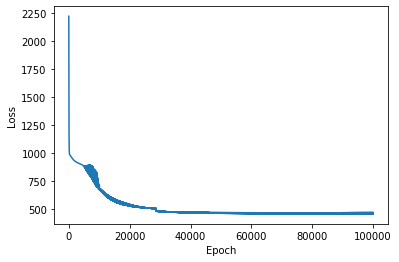

In [9]:
# 打印误差曲线
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

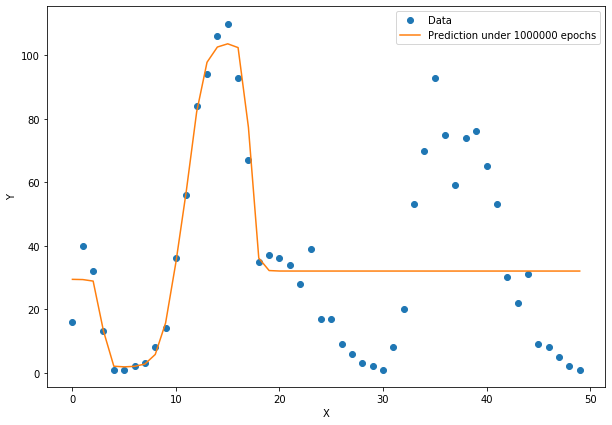

In [10]:
x_data = x.data.numpy() # 获得x包裹的数据
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') # 绘制原始数据

yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X') #更改坐标轴标注
plt.ylabel('Y') #更改坐标轴标注
plt.legend([xplot, yplot],['Data', 'Prediction under 1000000 epochs']) #绘制图例
plt.show()

### 2. 改进版本

上面的程序之所以跑得很慢，是因为x的取值范围1～50。
而由于所有权重和biases的取值范围被设定为-1,1的正态分布随机数，这样就导致
我们输入给隐含层节点的数值范围为-50~50，
要想将sigmoid函数的多个峰值调节到我们期望的位置需要耗费很多的计算时间

我们的解决方案就是将输入变量的范围归一化

In [12]:
#取出最后一列的前50条记录来进行预测
counts = rides['cnt'][:50]

#创建归一化的变量x，它的取值是0.02,0.04,...,1
x = torch.tensor(np.arange(len(counts), dtype = float) / len(counts), requires_grad = True)

# 创建归一化的预测变量y，它的取值范围是0～1
y = torch.tensor(np.array(counts, dtype = float), requires_grad = True)

# 初始化所有神经网络的权重（weights）和阈值（biases）
weights = torch.randn((1, sz), dtype = torch.double, requires_grad = True) #1*10的输入到隐含层的权重矩阵
biases = torch.randn(sz, dtype = torch.double, requires_grad = True) #尺度为10的隐含层节点偏置向量
weights2 = torch.randn((sz, 1), dtype = torch.double, requires_grad = True) #10*1的隐含到输出层权重矩阵

learning_rate = 0.001 #设置学习率
losses = []

# 将 x 转换为(50,1)的维度，以便与维度为(1,10)的weights矩阵相乘
x = x.view(50, -1)
# 将 y 转换为(50,1)的维度
y = y.view(50, -1)

for i in range(100000):
    # 从输入层到隐含层的计算
    hidden = x * weights + biases
    # 将sigmoid函数作用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    # 隐含层输出到输出层，计算得到最终预测
    predictions = hidden.mm(weights2)# + biases2.expand_as(y)
    # 通过与标签数据y比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2) 
    losses.append(loss.data.numpy())
    
    # 每隔10000个周期打印一下损失函数数值
    if i % 10000 == 0:
        print('loss:', loss)
        
    #对损失函数进行梯度反传
    loss.backward()
    
    #利用上一步计算中得到的weights，biases等梯度信息更新weights或biases中的data数值
    weights.data.add_(- learning_rate * weights.grad.data)  
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    
    # 清空所有变量的梯度值。
    # 因为pytorch中backward一次梯度信息会自动累加到各个变量上，因此需要清空，否则下一次迭代会累加，造成很大的偏差
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()



loss: tensor(2198.2419, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(922.7035, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(655.1682, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(540.2125, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(499.8701, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(479.0000, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(437.5650, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(264.3866, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(111.3508, dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(61.5404, dtype=torch.float64, grad_fn=<MeanBackward1>)


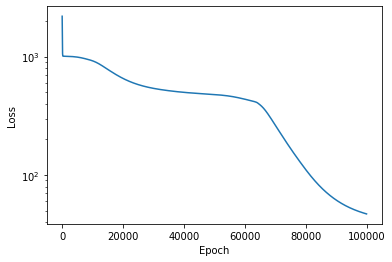

In [13]:
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

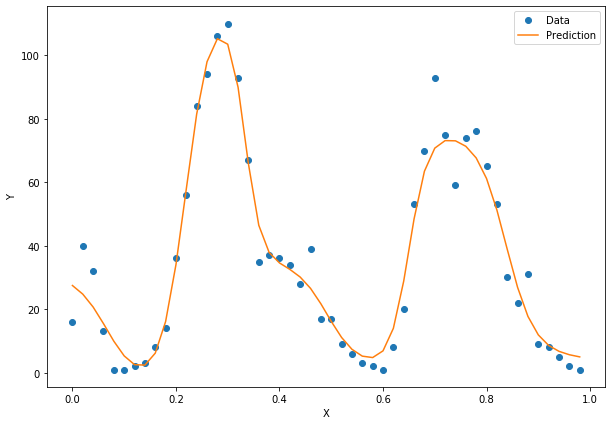

In [14]:
x_data = x.data.numpy() # 获得x包裹的数据
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') # 绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X') #更改坐标轴标注
plt.ylabel('Y') #更改坐标轴标注
plt.legend([xplot, yplot],['Data', 'Prediction']) #绘制图例
plt.show()

### 3. 用训练好的神经网络做预测

预测下50个节点

tensor(8641.0441, dtype=torch.float64, grad_fn=<MeanBackward1>)


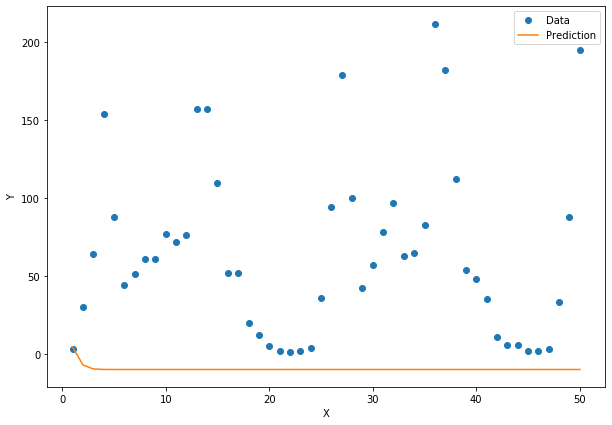

In [15]:
counts_predict = rides['cnt'][50:100] #读取待预测的接下来的50个数据点

#首先对接下来的50个数据点进行选取，注意x应该取51，52，……，100，然后再归一化
x = torch.tensor((np.arange(len(counts_predict), dtype = float) + len(counts) / len(counts_predict))
                 , requires_grad = True)

#读取下50个点的y数值，不需要做归一化
y = torch.tensor(np.array(counts_predict, dtype = float), requires_grad = True)

# 从输入层到隐含层的计算
hidden = x.expand(sz, len(x)).t() * weights.expand(len(x), sz) + biases.expand(len(x), sz)

# 将sigmoid函数作用在隐含层的每一个神经元上
hidden = torch.sigmoid(hidden)

# 隐含层输出到输出层，计算得到最终预测
predictions = hidden.mm(weights2)

# 计算预测数据上的损失函数
loss = torch.mean((predictions - y) ** 2) 
print(loss)


x_data = x.data.numpy() # 获得x包裹的数据
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') # 绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X') #更改坐标轴标注
plt.ylabel('Y') #更改坐标轴标注
plt.legend([xplot, yplot],['Data', 'Prediction']) #绘制图例
plt.show()

然而，预测发现存在着非常严重的过拟合现象！原因是x和y根本就没有关系！

## 三、人工神经网络Neu

在这一小节中，我们将再构建一个人工神经网络，利用数据库中的星期几、节假日、时间、风速等信息预测共享单车的使用数量

该神经网络有56个输入层节点、10个隐含层节点和1个输出节点

### 1. 数据的预处理过程

要读入其他的数据就要考虑到这些数据具有不同的数据类型，以及取值范围，所以要对它们进行预处理

另外，由于我们利用了全部数据来训练神经网络，所以采用之前介绍的一次性在全部数据上训练网络的方法就会很慢，
所以我们将数据划分成了不同的撮（batch），一个批次一个批次地训练神经网络，因此我们要对数据进行划分

In [30]:
#首先，让我们再来看看数据长什么样子
#读取数据到内存中，rides为一个dataframe对象
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### a. 对于类型变量的处理

有很多变量都属于类型变量，例如season=1,2,3,4，分四季。我们不能将season变量直接输入到神经网络，这是因为season数值越高并不表示相应的信号强度越大。我们的解决方案是将类型变量用一个“一位热码“（one-hot）来编码，也就是：

$
season = 1 \rightarrow (1, 0, 0 ,0) \\
season = 2 \rightarrow (0, 1, 0, 0) \\
season = 3 \rightarrow (0, 0, 1, 0) \\
season = 4 \rightarrow (0, 0, 0, 1) \\
$

因此，如果一个类型变量有n个不同取值，那么我们的“一位热码“所对应的向量长度就为n

In [31]:
#对于类型变量的特殊处理
# season=1,2,3,4, weathersi=1,2,3, mnth= 1,2,...,12, hr=0,1, ...,23, weekday=0,1,...,6
# 经过下面的处理后，将会多出若干特征，例如，对于season变量就会有 season_1, season_2, season_3, season_4
# 这四种不同的特征。
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    #利用pandas对象，我们可以很方便地将一个类型变量属性进行one-hot编码，变成多个属性
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


#### b. 对于数值类型变量进行标准化
由于每个数值型变量都是相互独立的，所以它们的数值绝对大小与问题本身没有关系，为了消除数值大小的差异，我们对每一个数值型变量进行标准化处理，也就是让其数值都围绕着0左右波动。比如，对于温度temp这个变量来说，它在整个数据库取值的平均着为mean(temp), 方差为std(temp)，所以，归一化的温度计算为：

$ temp'=\frac{temp - mean(temp)}{std(temp)}$

这样做的好处就是可以将不同的取值范围的变量设置为让它们处于一个平等的地位。

In [32]:
# 调整所有的特征，标准化处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
#quant_features = ['temp', 'hum', 'windspeed']

# 我们将每一个变量的均值和方差都存储到scaled_features变量中。
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

#### c. 将数据集进行分割

In [33]:
# 将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集，其它是训练集
test_data = data[-21*24:]
train_data = data[:-21*24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

# 将我们的数据列分为特征列和目标列

#目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据从pandas dataframe转换为numpy
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1])
losses = []

训练数据： 16875 测试数据： 504


In [34]:
features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### 2. 构建神经网络并进行训练

#### a. 手动编写用Tensor运算的人工神经网络

In [38]:
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1] #输入层单元个数
hidden_size = 10 #隐含层单元个数
output_size = 1 #输出层单元个数
batch_size = 128 #每隔batch的记录数
weights1 = torch.randn([input_size, hidden_size], dtype = torch.double,  requires_grad = True) #第一到二层权重
biases1 = torch.randn([hidden_size], dtype = torch.double, requires_grad = True) #隐含层偏置
weights2 = torch.randn([hidden_size, output_size], dtype = torch.double, requires_grad = True) #隐含层到输出层权重
def neu(x):
    #计算隐含层输出
    #x为batch_size * input_size的矩阵，weights1为input_size*hidden_size矩阵，
    #biases为hidden_size向量，输出为batch_size * hidden_size矩阵    
    hidden = x.mm(weights1) + biases1.expand(x.size()[0], hidden_size)
    hidden = torch.sigmoid(hidden)
    
    #输入batch_size * hidden_size矩阵，mm上weights2, hidden_size*output_size矩阵，
    #输出batch_size*output_size矩阵
    output = hidden.mm(weights2)
    return output
def cost(x, y):
    # 计算损失函数
    error = torch.mean((x - y)**2)
    return error
def zero_grad():
    # 清空每个参数的梯度信息
    if weights1.grad is not None and biases1.grad is not None and weights2.grad is not None:
        weights1.grad.data.zero_()
        weights2.grad.data.zero_()
        biases1.grad.data.zero_()
def optimizer_step(learning_rate):
    # 梯度下降算法
    weights1.data.add_(- learning_rate * weights1.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases1.data.add_(- learning_rate * biases1.grad.data)

In [39]:
# 神经网络训练循环
losses = []
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype = torch.double, requires_grad = True)
        yy = torch.tensor(Y[start:end], dtype = torch.double, requires_grad = True)
        predict = neu(xx)
        loss = cost(predict, yy)
        zero_grad()
        loss.backward()
        optimizer_step(0.01)
        batch_loss.append(loss.data.numpy())
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 2.235044770123704
100 0.3997346107582024
200 0.29852800649649425
300 0.2488330442172633
400 0.19074098791973979
500 0.15217978164572513
600 0.12899055799223422
700 0.11318556233607077
800 0.10170043384797137
900 0.09371229443925799


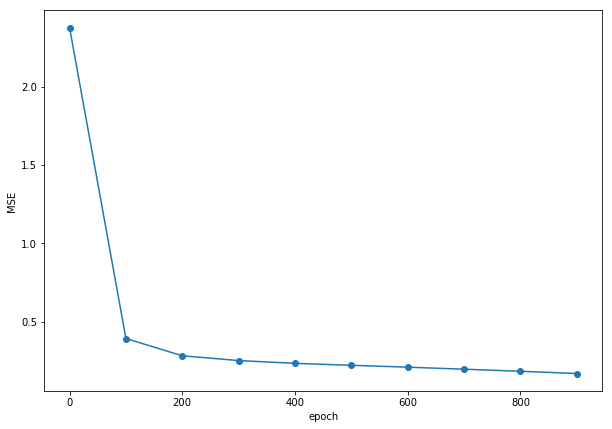

In [45]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

#### b. 调用PyTorch现成的函数，构建序列化的神经网络

In [46]:
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)


In [50]:
# 神经网络训练循环
losses = []
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(Y[start:end], dtype = torch.float, requires_grad = True)
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.91175205
100 0.272255
200 0.22915187
300 0.16811317
400 0.11858976
500 0.09042114
600 0.07775351
700 0.07055467
800 0.065846086
900 0.06277312


Text(0, 0.5, 'MSE')

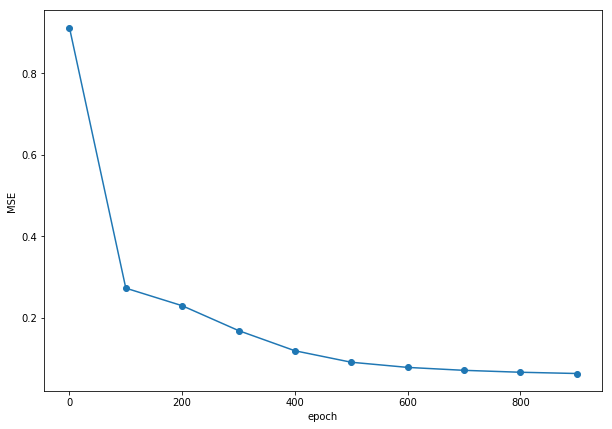

In [51]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

### 3. 测试神经网络

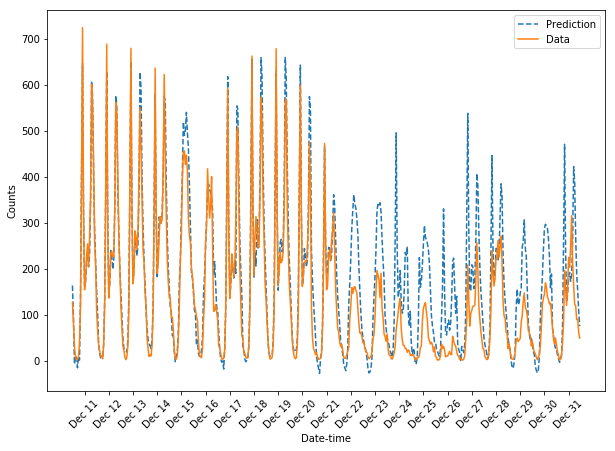

In [53]:
# 用训练好的神经网络在测试集上进行预测
targets = test_targets['cnt'] #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1]) #将数据转换成合适的tensor形式
targets = targets.astype(float) #保证数据为实数

# 将属性和预测变量包裹在Variable型变量中
x = torch.tensor(test_features.values, dtype = torch.float, requires_grad = True)
y = torch.tensor(targets, dtype = torch.float, requires_grad = True)

# 用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()


# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle = '--')
ax.plot(targets * std + mean, label='Data', linestyle = '-')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

### 4. 诊断网络*

在这一小节我们对网络出现的问题进行诊断，看看哪一些神经元导致了预测偏差(集智AI学园出品，欢迎访问http://campus.swarma.org)

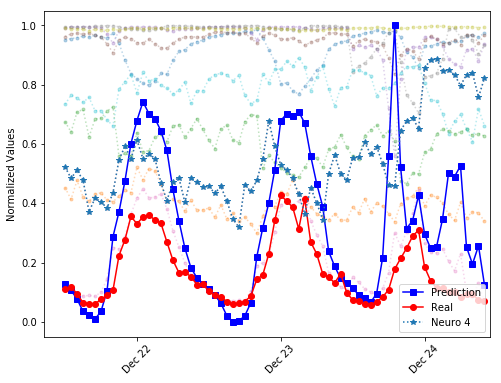

In [57]:
# 选出三天预测不准的日期：Dec 22，23，24
# 将这三天的数据聚集到一起，存入subset和subtargets中
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

# 将三个布尔型数组求与
bools = [any(tup) for tup in zip(bool1,bool2,bool3) ]
# 将相应的变量取出来
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets),1])

def feature(X, net):
    # 定义了一个函数可以提取网络的权重信息，所有的网络参数信息全部存储在了neu的named_parameters集合中了
    X = torch.tensor(X, dtype = torch.float, requires_grad = False)
    dic = dict(net.named_parameters()) #提取出来这个集合
    weights = dic['0.weight'] #可以按照层数.名称来索引集合中的相应参数值
    biases = dic['0.bias'] #可以按照层数.名称来索引集合中的相应参数值
    h = torch.sigmoid(X.mm(weights.t()) + biases.expand([len(X), len(biases)])) # 隐含层的计算过程
    return h # 输出层的计算

# 将这几天的数据输入到神经网络中，读取出隐含层神经元的激活数值，存入results中
results = feature(subset.values, neu).data.numpy()
# 这些数据对应的预测值（输出层）
predict = neu(torch.tensor(subset.values, dtype = torch.float, requires_grad = True)).data.numpy()

#将预测值还原成原始数据的数值范围
mean, std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean
# 将所有的神经元激活水平画在同一张图上，蓝色的是模型预测的数值
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(results[:,:],'.:',alpha = 0.3)
ax.plot((predict - min(predict)) / (max(predict) - min(predict)),'bs-',label='Prediction')
ax.plot((subtargets - min(predict)) / (max(predict) - min(predict)),'ro-',label='Real')
ax.plot(results[:, 3],':*',alpha=1, label='Neuro 4')

ax.set_xlim(right=len(predict))
ax.legend()
plt.ylabel('Normalized Values')

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

Text(0, 0.5, 'Weight')

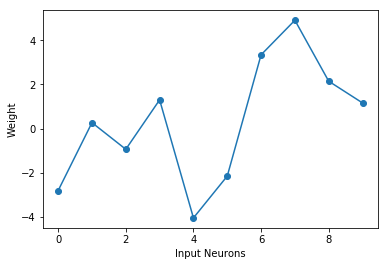

In [58]:
# 找到了与峰值响应的神经元，把它到输入层的权重输出出来
dic = dict(neu.named_parameters())
weights = dic['2.weight']
plt.plot(weights.data.numpy()[0],'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

In [62]:
for para in neu.named_parameters():
    print(para) 

('0.weight', Parameter containing:
tensor([[-1.7122e-01,  4.5277e-01, -1.1202e+00,  1.3197e-01,  7.7733e-02,
          5.9270e-01,  1.0462e-01,  2.8778e-02, -2.2272e-03,  8.6722e-02,
          2.0251e-01,  4.7237e-01, -6.0219e-03,  3.5042e-01,  3.2314e-01,
          2.3997e-01,  5.0274e-02, -3.5867e-02, -9.3248e-02, -2.4897e-01,
          2.7037e-01,  1.5166e-01, -8.4814e-02,  1.0247e-01, -4.1041e-02,
          3.9482e-01,  5.5091e-01,  5.8641e-01,  7.4069e-01,  8.2917e-01,
          8.3721e-01,  7.3720e-01,  6.0184e-01,  1.0378e+00,  2.5071e-01,
         -4.4226e-01, -6.8018e-01, -8.4533e-01, -6.9797e-01, -7.4660e-01,
         -7.1730e-01, -6.0265e-01, -6.6014e-01, -5.1221e-01, -2.5779e-01,
         -6.2221e-02,  1.9414e-02,  1.6186e-01,  3.1734e-01,  1.2918e-02,
          1.2963e-01,  2.2257e-01,  2.2130e-01,  2.3192e-01,  3.8277e-01,
         -1.2432e-01],
        [-2.1720e-01,  7.7831e-02,  2.0407e-01,  2.2429e-02,  7.3162e-02,
         -3.0799e-03,  8.9186e-02, -5.5109e-02, -7.331

Text(0, 0.5, 'Weight')

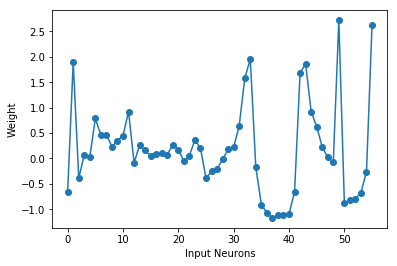

In [64]:
# 找到了与峰值相应的神经元，把它到输入层的权重输出出来
dic = dict(neu.named_parameters())
weights = dic['0.weight'][7]
plt.plot(weights.data.numpy(),'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

In [61]:
# 列出所有的features中的数据列，找到对应的编号
for (i, c) in zip(range(len(features.columns)), features.columns):
    print(i,c)

0 yr
1 holiday
2 temp
3 hum
4 windspeed
5 season_1
6 season_2
7 season_3
8 season_4
9 weathersit_1
10 weathersit_2
11 weathersit_3
12 weathersit_4
13 mnth_1
14 mnth_2
15 mnth_3
16 mnth_4
17 mnth_5
18 mnth_6
19 mnth_7
20 mnth_8
21 mnth_9
22 mnth_10
23 mnth_11
24 mnth_12
25 hr_0
26 hr_1
27 hr_2
28 hr_3
29 hr_4
30 hr_5
31 hr_6
32 hr_7
33 hr_8
34 hr_9
35 hr_10
36 hr_11
37 hr_12
38 hr_13
39 hr_14
40 hr_15
41 hr_16
42 hr_17
43 hr_18
44 hr_19
45 hr_20
46 hr_21
47 hr_22
48 hr_23
49 weekday_0
50 weekday_1
51 weekday_2
52 weekday_3
53 weekday_4
54 weekday_5
55 weekday_6


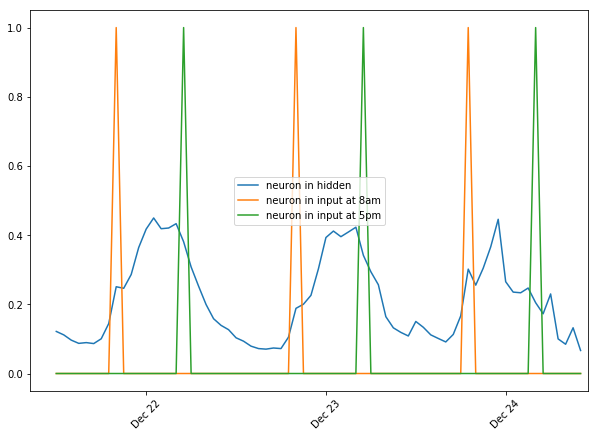

In [65]:
# 显示在不同日期，指定的第7个隐含层神经元细胞的激活值，以及输入层响应
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(results[:,6],label='neuron in hidden')
ax.plot(subset.values[:,33],label='neuron in input at 8am')
ax.plot(subset.values[:,42],label='neuron in input at 5pm')
ax.set_xlim(right=len(predict))
ax.legend()

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 4. 分类人工神经网络Neuc

本小节中，我们解决一个分类问题，即将预测数值根据大于或者小于预测数量的平均值来分成两类
我们只需要对Neuc进行小小的更改，将其输出单元数量设置为2，并加上Sigmoid函数就可以了

对于Neuc来说，它的输出是两个数值，分别表示属于第0类和第1类的概率(集智AI学园出品，欢迎访问http://campus.swarma.org)

In [69]:
# 重新构造用于分类的人工神经网络Neuc

input_size = features.shape[1]
hidden_size = 10
output_size = 2
batch_size = 128
neuc = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Sigmoid(),
)
# 将损失函数定义为交叉熵
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(neuc.parameters(), lr = 0.1)

In [70]:
Y_labels = Y > np.mean(Y)
Y_labels = Y_labels.astype(int)
Y_labels = Y_labels.reshape(-1)
Y_labels

array([0, 0, 0, ..., 1, 1, 1])

In [73]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
    predictions = np.argmax(predictions, 1)
    return 100.0 - (
      100.0 *
      np.sum( predictions == labels) /
      predictions.shape[0])

# 神经网络训练循环
losses = []
errors = []
for i in range(4000):
    # 每128个样本点被划分为一个撮
    batch_loss = []
    batch_errors = []
    for start, end in zip(range(0, len(X), batch_size), range(batch_size, len(X)+1, batch_size)):
        xx = torch.tensor(X[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(Y_labels[start:end], dtype = torch.long)
        predict = neuc(xx)
        loss = cost(predict, yy)
        err = error_rate(predict.data.numpy(), yy.data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        batch_errors.append(err)
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        errors.append(np.mean(batch_errors))
        print(i, np.mean(batch_loss), np.mean(batch_errors))

0 0.67610335 39.87356870229008
100 0.44330817 12.810114503816793
200 0.43371433 12.177958015267176
300 0.42899755 11.92151717557252
400 0.41564882 10.048902671755725
500 0.40300307 8.540076335877863
600 0.39274073 7.406965648854962
700 0.38582948 6.6913167938931295
800 0.38150108 6.285782442748092
900 0.37869146 6.0770515267175576
1000 0.37656036 5.892175572519084
1100 0.3747908 5.778864503816794
1200 0.37325028 5.677480916030534
1300 0.3718631 5.480677480916031
1400 0.37058702 5.319656488549619
1500 0.3694193 5.206345419847328
1600 0.36837056 5.039360687022901
1700 0.36743784 4.9439408396946565
1800 0.36660895 4.878339694656488
1900 0.36586848 4.830629770992366
2000 0.3652017 4.753101145038168
2100 0.36459625 4.6875
2200 0.36404246 4.675572519083969
2300 0.36353254 4.651717557251908
2400 0.36305955 4.604007633587786
2500 0.36261714 4.5741889312977095
2600 0.3621994 4.532442748091603
2700 0.36180353 4.4728053435114505
2800 0.36143062 4.46087786259542
2900 0.3610801 4.419131679389313
30

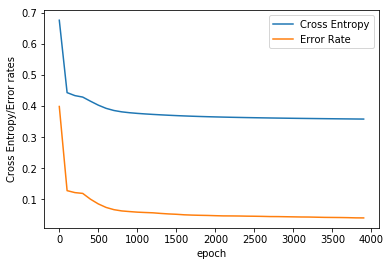

In [74]:
# 打印输出损失值
plt.plot(np.arange(len(losses))*100,losses, label = 'Cross Entropy')
plt.plot(np.arange(len(losses))*100, np.array(errors) / float(100), label = 'Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error rates')
plt.legend()

对分类效果进行测试

13.69047619047619


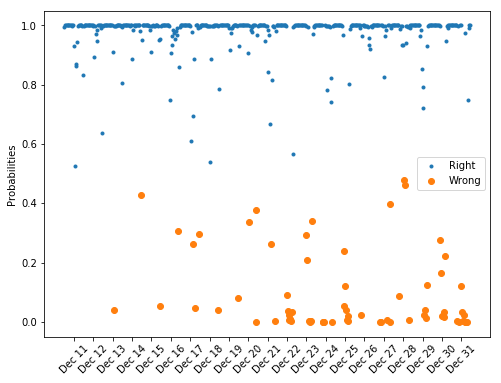

In [75]:
# 读取测试数据
targets = test_targets['cnt']
targets = targets.values.reshape([len(targets), 1])
Y_labels = targets > np.mean(Y)
Y_labels = Y_labels.astype(int)
Y_labels = Y_labels.reshape(-1)
x = torch.tensor(test_features.values, dtype = torch.float, requires_grad = True)

# 打印神经网络预测的错误率
predict = neuc(x)
print(error_rate(predict.data.numpy(), Y_labels))

# 接下来，我们把预测正确的数据和错误的数据分别画出来，纵坐标分别是预测正确的概率和预测错误的概率
prob = predict.data.numpy()
rights = np.argmax(prob, 1) == Y_labels
wrongs = np.argmax(prob, 1) != Y_labels
right_labels = Y_labels[rights]
wrong_labels = Y_labels[wrongs]
probs = prob[rights, :]
probs1 = prob[wrongs, :]
rightness = [probs[i, right_labels[i]] for i in range(len(right_labels))]
right_index = np.arange(len(targets))[rights]
wrongness = [probs1[i, wrong_labels[i]] for i in range(len(wrong_labels))]
wrong_index = np.arange(len(targets))[wrongs]
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(right_index, rightness, '.', label='Right')
ax.plot(wrong_index, wrongness,'o',label='Wrong')

ax.legend()
plt.ylabel('Probabilities')

dates = pd.to_datetime(rides.loc[test_features.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

集智AI学园出品，欢迎访问http://campus.swarma.org